In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/fire2021/train.csv')

**Data Imbalance : Lesser examples for Threatening tweets**

[Text(0, 0, 'NON-THR '), Text(0, 0, 'THR ')]

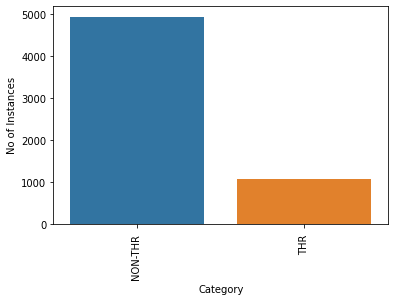

In [8]:
import seaborn as sns
ax = sns.countplot(x='target',data=df)
ax.set_xlabel('Category')
ax.set_ylabel('No of Instances')
ax.set_xticklabels(['NON-THR ','THR '], rotation='vertical', fontsize=10)

In [ ]:
df['target'].value_counts()

0    4929
1    1071
Name: target, dtype: int64

In [ ]:
import copy
clean_tweets = copy.deepcopy(df[["tweet"]])

Urduhack is a Natural Language Processing (NLP) library for urdu language. Training data was **normalized** using normalization module from urduhack to eliminate characters from other languages like arabic.

In [ ]:
!pip install Urduhack[tf-gpu]

In [ ]:
from urduhack import normalize
from tqdm import tqdm
tqdm.pandas(desc="Normalizing Data...")
clean_tweets['tweet'] = clean_tweets['tweet'].progress_apply(normalize)

Normalizing Data...: 100%|██████████| 6000/6000 [00:00<00:00, 73625.61it/s]


In [ ]:
raw_tweets = clean_tweets['tweet'].tolist()
raw_labels = df['target'].tolist()

In [ ]:
pip install imbalanced-learn

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.4.3


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)

In [ ]:
from sklearn.model_selection import train_test_split
train_tweets, val_tweets, train_labels, val_labels = train_test_split(raw_tweets, raw_labels, test_size=0.1,random_state=42)

In [ ]:
import numpy as np

In [ ]:
# fit and apply the transform
train_tweets, train_labels = oversample.fit_resample(np.array(train_tweets).reshape(-1, 1), train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(unique, counts) = np.unique(train_labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)


[[   0 4448]
 [   1 2224]]


In [ ]:
train_tweets = train_tweets.reshape(-1,)

In [ ]:
pip install transformers

**Using a pretrained model from hugging face**<br>
Language model: roberta-urdu-small<br>
Model size: 125M<br> 
Language: Urdu <br>
Training data: News data from urdu news resources in Pakistan<br>
[roberta-urdu-small](https://huggingface.co/urduhack/roberta-urdu-small)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 
checkpoint = "urduhack/roberta-urdu-small" 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
train_encodings = tokenizer(list(train_tweets), truncation=True, padding=True,max_length = 256)
val_encodings = tokenizer(val_tweets, truncation=True, padding=True,max_length = 256)

In [ ]:
import torch
class tweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [ ]:
train_dataset = tweetDataset(train_encodings, train_labels)
val_dataset = tweetDataset(val_encodings, val_labels)

**Fine Tuning model on the HASOC threat detection dataset**

In [ ]:
from torch import nn
from transformers import Trainer, TrainingArguments

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,
    evaluation_strategy = 'steps',
    save_strategy = 'steps',         # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    metric_for_best_model = 'eval_f1',
    save_total_limit = 10,
    save_steps = 100,
    eval_steps = 100,
    load_best_model_at_end = True
)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 10)],
    compute_metrics=compute_metrics
)
trainer.train()

Some weights of the model checkpoint at urduhack/roberta-urdu-small were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at urduhack/roberta-urdu-small and are new

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.641400,0.529982,0.796667,0.465116,0.168067,0.246914
200,0.548300,0.458551,0.785000,0.454545,0.420168,0.436681
300,0.508400,0.436938,0.796667,0.489051,0.563025,0.523438
400,0.455400,0.576766,0.715000,0.380734,0.697479,0.492582
500,0.409900,0.676238,0.676667,0.341772,0.680672,0.455056
600,0.361000,0.554066,0.815000,0.540816,0.445378,0.488479
700,0.330800,0.561608,0.828333,0.700000,0.235294,0.352201
800,0.316400,0.673741,0.830000,0.587629,0.478992,0.527778
900,0.201400,0.715493,0.828333,0.633333,0.319328,0.424581
1000,0.158500,0.794921,0.815000,0.536364,0.495798,0.515284


***** Running Evaluation *****
  Num examples = 600
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 600
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 600
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json
Model weights saved in ./results/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 600
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json
Model weights saved in ./results/checkpoint-400/pytorch_model.bin
***** Ru

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.641400,0.529982,0.796667,0.465116,0.168067,0.246914
200,0.548300,0.458551,0.785000,0.454545,0.420168,0.436681
300,0.508400,0.436938,0.796667,0.489051,0.563025,0.523438
400,0.455400,0.576766,0.715000,0.380734,0.697479,0.492582
500,0.409900,0.676238,0.676667,0.341772,0.680672,0.455056
600,0.361000,0.554066,0.815000,0.540816,0.445378,0.488479
700,0.330800,0.561608,0.828333,0.700000,0.235294,0.352201
800,0.316400,0.673741,0.830000,0.587629,0.478992,0.527778
900,0.201400,0.715493,0.828333,0.633333,0.319328,0.424581
1000,0.158500,0.794921,0.815000,0.536364,0.495798,0.515284


***** Running Evaluation *****
  Num examples = 600
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json
Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-800 (score: 0.5277777777777778).


TrainOutput(global_step=1251, training_loss=0.3403495068935086, metrics={'train_runtime': 461.4822, 'train_samples_per_second': 43.373, 'train_steps_per_second': 2.711, 'total_flos': 524585888844480.0, 'train_loss': 0.3403495068935086, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(val_dataset)
import numpy as np
preds = np.argmax(predictions.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 600
  Batch size = 64


**Evaluation :**

In [ ]:
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
print("Weighted f1 : ",f1_score(val_labels, preds,average='weighted'))
print("Macro f1 : ",f1_score(val_labels, preds,average='macro'))
print("Accuracy : ",accuracy_score(val_labels, preds))
print("conf matrix : ",confusion_matrix(val_labels, preds),sep='\n')

Weighted f1 :  0.8232429990966575
Macro f1 :  0.712059620596206
Accuracy :  0.83
conf matrix : 
[[441  40]
 [ 62  57]]


In [ ]:
model_dir = '/content/drive/MyDrive/fire2021/'

**Saving fine tuned model**

In [ ]:
trainer.save_model(model_dir + 'fineTuned_final/model')

Saving model checkpoint to /content/drive/MyDrive/fire2021/fineTuned_final/model
Configuration saved in /content/drive/MyDrive/fire2021/fineTuned_final/model/config.json
Model weights saved in /content/drive/MyDrive/fire2021/fineTuned_final/model/pytorch_model.bin


**Loading the saved model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_dir + 'fineTuned_final/model', 
                                                        local_files_only=True)

loading configuration file /content/drive/MyDrive/fire2021/fineTuned_final/model/config.json
Model config RobertaConfig {
  "_name_or_path": "urduhack/roberta-urdu-small",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.9.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading weights file /content/drive/MyDrive/fire2021/fineTuned_final/model/pytorch_model.bin
All model checkpoint weights wer

**Making prediction**

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/fire2021/test.csv')

In [ ]:
clean_tweets_test = copy.deepcopy(df_test[["tweet"]])

In [ ]:
clean_tweets_test['tweet'] = clean_tweets_test['tweet'].progress_apply(normalize)

Normalizing Data...: 100%|██████████| 3950/3950 [00:00<00:00, 72044.83it/s]


In [ ]:
raw_tweets_test = clean_tweets_test['tweet'].tolist()

In [ ]:
test_encodings = tokenizer(raw_tweets_test, truncation=True, padding=True,max_length = 256)

In [ ]:
test_dataset = tweetDataset(test_encodings)

In [ ]:
test_trainer = Trainer(model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
raw_pred, _, _ = test_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 3950
  Batch size = 8


In [ ]:
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
score = raw_pred[:, 1]

In [ ]:
df_test['target'] = y_pred

In [ ]:
df_test['score'] = score

In [ ]:
df_test = df_test.drop('tweet', axis=1)

In [ ]:
df_test.to_csv('roberta_fineTuned.csv', index=False)

In [ ]:
 import torch
 torch.cuda.empty_cache()